In [186]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "../take-home-interview/"

In [3]:
app = pd.read_csv(data_path + "loan_application.csv")
balance = pd.read_csv(data_path + "aave_loan_balance.csv")

In [5]:
app.head()

,application_id_current,target,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_113,col_114,col_115,col_116,col_117,col_118,col_119,col_120,col_121,type
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,3,1,8,6,5,2,0,5,0,train
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,1,1,3,1,39,2,0,0,0,train
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,3,1,8,1,11,4,3,7,2,train
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,1,8,6,5,4,3,7,2,train
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,3,1,3,4,37,4,3,7,2,train


In [4]:
balance.head()

,application_id_previous,application_id_current,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


### 기초 통계량

In [152]:
app_id_set = set(app.application_id_current)
bal_id_set = set(balance.application_id_current)

In [154]:
app_id_count = len(app_id_set)
inter_count = len(app_id_set&bal_id_set)
print(f"Aaev 대출 기록이 있는 대출 요청: {inter_count:,}({inter_count/app_id_count*100:.2f}%)")

Aaev 대출 기록이 있는 대출 요청: 103,558(29.07%)


In [161]:
## 대출 기록이 있는 경우가 상환률이 좀 더 높다
aaev_loan_target_mean = app.loc[app.application_id_current.isin(bal_id_set), 'target'].mean()
no_aaev_loan_target_mean = app.loc[~app.application_id_current.isin(bal_id_set), 'target'].mean()
print(f"Aaev 대출 기록이 있는 요청의 상환률: {aaev_loan_target_mean*100:.2f}%")
print(f"Aaev 대출 기록이 없는 요청의 상환률: {no_aaev_loan_target_mean*100:.2f}%")

Aaev 대출 기록이 있는 요청의 상환률: 8.67%
Aaev 대출 기록이 없는 요청의 상환률: 7.84%


In [108]:
## 거의 대부분이 1번의 대출기록이 존재
balance.groupby("application_id_current").application_id_previous.nunique().value_counts().sort_index()

1    102818
2       732
3         7
4         1
Name: application_id_previous, dtype: int64

In [ ]:
balance = balance.assign(contract_completed = balance.name_contract_status == 'Completed')

app_contract_completed = balance.groupby('application_id_current').contract_completed.sum().reset_index(name='contract_completed')

app_contract_completed_target = app[['application_id_current', 'target']].merge(app_contract_completed, on='application_id_current')

for target, group in app_contract_completed_target.groupby("target"):
    print(f"{target}의 completed 비율: {(group.contract_completed>0).mean()*100:.2f}%")

In [165]:
app_prev_loan = (
    balance.groupby("application_id_current").application_id_previous.nunique().reset_index(name='loan_prev_count')
    .merge(
        app[['application_id_current', 'target']], how='right'
    )
)

In [167]:
app_prev_loan.loan_prev_count = app_prev_loan.loan_prev_count.fillna(0).astype(int)

In [173]:
app_prev_loan.groupby("loan_prev_count").size().sort_index()

loan_prev_count
0    252697
1    102818
2       732
3         7
4         1
dtype: int64

<AxesSubplot:xlabel='loan_prev_count'>

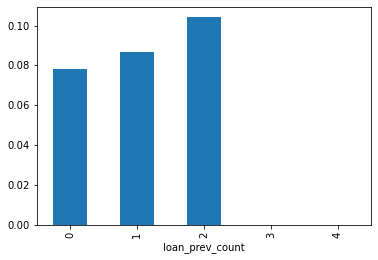

In [171]:
## 2회까지는 과거 대출 기록이 있을수록 상환율이 올라간다
app_prev_loan.groupby("loan_prev_count").target.mean().sort_index().plot.bar()

### Missing

In [162]:
balance_na = balance.isna()
na_df = pd.concat([balance_na.mean(), balance_na.sum()], axis=1)
na_df.columns = ['ratio', 'count']
na_df[na_df['count']>0]

,ratio,count
amt_drawings_atm_current,0.195249,749816
amt_drawings_other_current,0.195249,749816
amt_drawings_pos_current,0.195249,749816
amt_inst_min_regularity,0.079482,305236
amt_payment_current,0.199981,767988
cnt_drawings_atm_current,0.195249,749816
cnt_drawings_other_current,0.195249,749816
cnt_drawings_pos_current,0.195249,749816
cnt_instalment_mature_cum,0.079482,305236
target,0.159452,612347


### name_contract_status

In [114]:
balance.name_contract_status.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: name_contract_status, dtype: int64

In [117]:
balance_refused = balance[balance.name_contract_status == "Refused"]

In [119]:
row = balance_refused.iloc[0]

In [122]:
pd.options.display.max_rows=200

In [123]:
balance[(balance.application_id_previous == row.application_id_previous)&(balance.application_id_current == row.application_id_current)].sort_values('months_balance')

,application_id_previous,application_id_current,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,amt_payment_current,amt_payment_total_current,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def,amt_balance_scaled,target,amt_credit_limit_actual_scaled
301915,1282349,371555,-91,0.000,90000,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.000,0.000,0.000,NaN,0,NaN,NaN,NaN,Refused,0,0,12.948608,False,11.407576
2023249,1282349,371555,-90,69440.040,90000,67500.0,67500.0,0.0,0.0,NaN,0.00,0.00,67500.000,69440.040,69440.040,2.0,2,0.0,0.0,NaN,Active,0,0,13.101530,False,11.407576
2968468,1282349,371555,-89,67868.685,90000,0.0,0.0,0.0,0.0,4500.00,4500.00,4500.00,64940.040,67868.685,67868.685,0.0,0,0.0,0.0,1.0,Active,0,0,13.098316,False,11.407576
2285980,1282349,371555,-88,89213.265,90000,22500.0,22500.0,0.0,0.0,4500.00,4500.00,4500.00,85868.685,89213.265,89213.265,1.0,1,0.0,0.0,2.0,Active,0,0,13.141115,False,11.407576
2417727,1282349,371555,-87,88051.140,90000,0.0,0.0,0.0,0.0,4500.00,4500.00,4500.00,84713.265,88051.140,88051.140,0.0,0,0.0,0.0,3.0,Active,0,0,13.138832,False,11.407576
1701834,1282349,371555,-86,86906.700,90000,0.0,0.0,0.0,0.0,4500.00,4500.00,4500.00,83551.140,86906.700,86906.700,0.0,0,0.0,0.0,4.0,Active,0,0,13.136578,False,11.407576
3002490,1282349,371555,-85,81144.045,90000,0.0,0.0,0.0,0.0,4500.00,9000.00,9000.00,78428.610,81144.045,81144.045,0.0,0,0.0,0.0,5.0,Active,0,0,13.125150,False,11.407576
663065,1282349,371555,-84,79837.740,90000,0.0,0.0,0.0,0.0,4500.00,4500.00,4500.00,76644.045,79837.740,79837.740,0.0,0,0.0,0.0,6.0,Active,0,0,13.122541,False,11.407576
937449,1282349,371555,-83,73914.930,90000,0.0,0.0,0.0,0.0,4500.00,9000.00,9000.00,70837.740,73914.930,73914.930,0.0,0,0.0,0.0,7.0,Active,0,0,13.110627,False,11.407576
2773863,1282349,371555,-82,70121.205,90000,0.0,0.0,0.0,0.0,4500.00,6750.00,6750.00,67164.930,70121.205,70121.205,0.0,0,0.0,0.0,8.0,Active,0,0,13.102920,False,11.407576


In [ ]:
balance.groupby()

In [146]:
balance = balance.assign(contract_completed = balance.name_contract_status == 'Completed')

app_contract_completed = balance.groupby('application_id_current').contract_completed.sum().reset_index(name='contract_completed')

app_contract_completed_target = app[['application_id_current', 'target']].merge(app_contract_completed, on='application_id_current')

for target, group in app_contract_completed_target.groupby("target"):
    print(f"{target}의 completed 비율: {(group.contract_completed>0).mean()*100:.2f}%")

0.0의 completed 비율: 12.45%
1.0의 completed 비율: 9.66%


In [151]:
for status in balance.name_contract_status.unique():
    balance = balance.assign(contract_completed = balance.name_contract_status == status)

    app_contract_completed = balance.groupby('application_id_current').contract_completed.sum().reset_index(name='contract_completed')

    app_contract_completed_target = app[['application_id_current', 'target']].merge(app_contract_completed, on='application_id_current')

    for target, group in app_contract_completed_target.groupby("target"):
        print(f"y가 {target}의 {status} 비율: {(group.contract_completed>0).mean()*100:.4f}%")
    print()

0.0의 Active 비율: 99.9219%
1.0의 Active 비율: 99.9336%

0.0의 Completed 비율: 12.4479%
1.0의 Completed 비율: 9.6629%

0.0의 Demand 비율: 0.0164%
1.0의 Demand 비율: 0.0265%

0.0의 Signed 비율: 4.9968%
1.0의 Signed 비율: 4.3138%

0.0의 Sent proposal 비율: 0.5569%
1.0의 Sent proposal 비율: 0.2389%

0.0의 Refused 비율: 0.0151%
1.0의 Refused 비율: 0.0265%

0.0의 Approved 비율: 0.0063%
1.0의 Approved 비율: 0.0000%



### months_balance

In [176]:
app_min_month = balance.groupby("application_id_current").months_balance.min()

app_min_month = app[['application_id_current', 'target']].merge(app_min_month, on='application_id_current')

<AxesSubplot:xlabel='months_balance', ylabel='Count'>

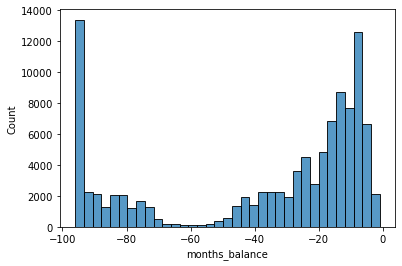

In [201]:
sns.histplot(data=app_min_month, x="months_balance")

In [200]:
# sns.histplot(data=app_min_month, x="months_balance", hue="target", stat="density")
# plt.show()

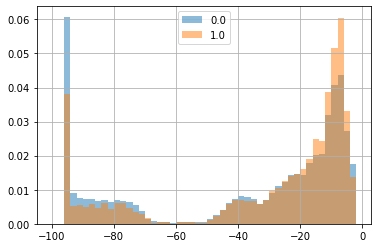

In [198]:
## 최대 대출 기간이 영향을 미치는 변수로 보인다
## 장기 대출한 사람들은 잘 갚지 못하는 경향성
leg = []
for target, group in app_min_month.groupby('target'):
    group.months_balance.hist(density=True, alpha=0.5, bins=np.arange(-100, 0, 2))
    leg.append(target)
plt.legend(leg)
plt.show()

In [ ]:
app_min_month = app[['application_id_current', 'target']].merge(app_min_month, on='application_id_current')

### amt_balance

In [202]:
app_max_balance = balance.groupby("application_id_current").amt_balance.max()

app_max_balance = app[['application_id_current', 'target']].merge(app_max_balance, on='application_id_current')

In [208]:
app_max_balance = app_max_balance.assign(max_amt_balance_scaled = (app_max_balance.amt_balance + 1).apply(np.log))

<AxesSubplot:xlabel='max_amt_balance_scaled', ylabel='Count'>

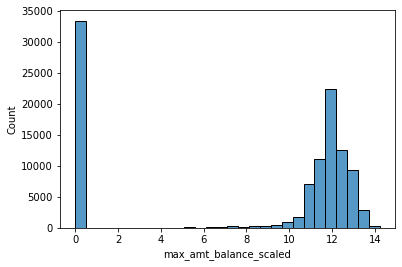

In [210]:
sns.histplot(data=app_max_balance, x="max_amt_balance_scaled")

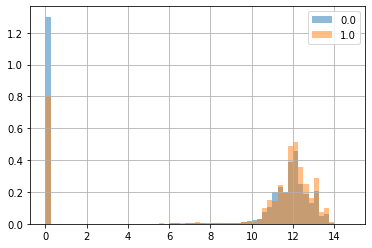

In [212]:
## 금액이 0원인 것을 뭘 의미하는지 모르겠지만, 0원이면 상환을 못하는 경우가 많아 보인다
leg = []
for target, group in app_max_balance.groupby('target'):
    group.max_amt_balance_scaled.hist(density=True, alpha=0.5, bins=np.arange(0, 15, 0.25))
    leg.append(target)
plt.legend(leg)
plt.show()

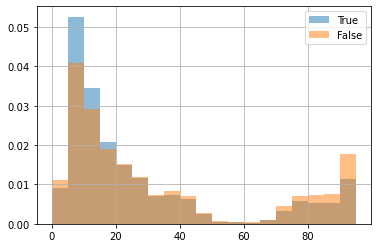

In [24]:
## 조금 대출한 애들이 상환을 잘하는 경향이 있다
balance_true_size = balance[balance.application_id_current.isin(ids_true)].groupby("application_id_current").size()
balance_true_size.hist(density=True, alpha=0.5, bins=np.arange(0, 100, 5))
balance_false_size = balance[balance.application_id_current.isin(ids_false)].groupby("application_id_current").size()
balance_false_size.hist(density=True, alpha=0.5, bins=np.arange(0, 100, 5))
plt.legend([True, False])
plt.show()

In [45]:
balance = balance.assign(target = None)
balance.loc[balance.application_id_current.isin(ids_true), 'target'] = True
balance.loc[balance.application_id_current.isin(ids_false), 'target'] = False

In [48]:
balance.target.isna().mean()

0.15945240907509597

In [49]:
balance.target.value_counts()

False    2997964
True      230001
Name: target, dtype: int64

In [50]:
balance.target.value_counts(normalize=True)

False    0.928747
True     0.071253
Name: target, dtype: float64

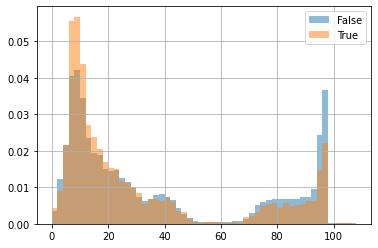

In [66]:
leg = []
for target, group in balance.groupby("target"):
    group.groupby("application_id_current").size().hist(density=True, alpha=0.5, bins=np.arange(0, 110, 2))
    leg.append(target)
plt.legend(leg)
plt.show()

### months_balance	

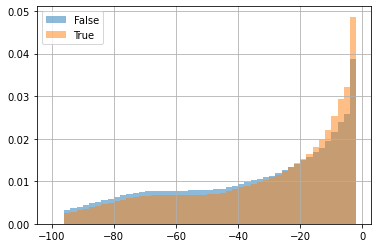

In [57]:
leg = []
for target, group in balance.groupby("target"):
    group.months_balance.hist(density=True, alpha=0.5, bins=np.arange(-100, 0, 2))
    leg.append(target)
plt.legend(leg)
plt.show()

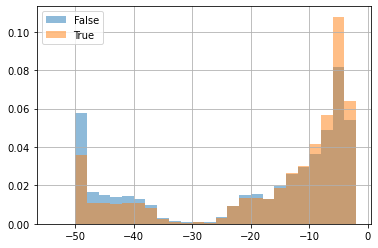

In [67]:
leg = []
for target, group in balance.groupby("target"):
    group.groupby('application_id_current').months_balance.mean().hist(density=True, alpha=0.5, bins=np.arange(-54, 0, 2))
    leg.append(target)
plt.legend(leg)
plt.show()

### amt_balance

In [32]:
balance.amt_balance.describe()

count    3.840312e+06
mean     5.830016e+04
std      1.063070e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      8.904669e+04
max      1.505902e+06
Name: amt_balance, dtype: float64

In [37]:
balance = balance.assign(amt_balance_scaled = (balance.amt_balance - balance.amt_balance.min() + 1).apply(np.log))

<AxesSubplot:>

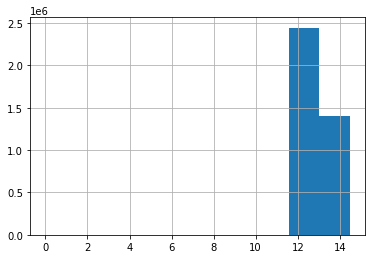

In [38]:
balance.amt_balance_scaled.hist()

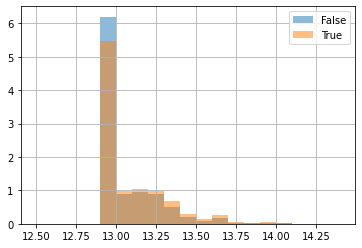

In [68]:
leg = []
for target, group in balance.groupby("target"):
    group.amt_balance_scaled.hist(density=True, alpha=0.5, bins=np.arange(12.5, 14.5, 0.1))
    leg.append(target)
plt.legend(leg)
plt.show()

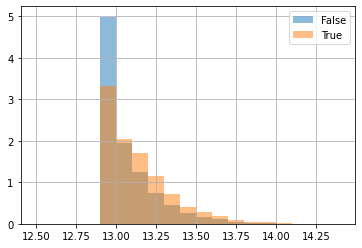

In [70]:
leg = []
for target, group in balance.groupby("target"):
    group.groupby("application_id_current").amt_balance_scaled.mean().hist(density=True, alpha=0.5, bins=np.arange(12.5, 14.5, 0.1))
    leg.append(target)
plt.legend(leg)
plt.show()

### amt_credit_limit_actual

In [80]:
balance = balance.assign(amt_credit_limit_actual_scaled = (balance.amt_credit_limit_actual+1).apply(np.log))

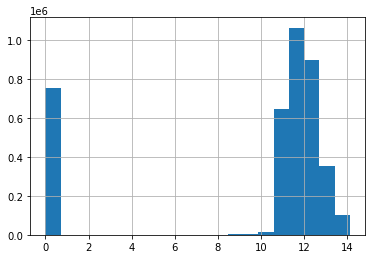

In [82]:
balance.amt_credit_limit_actual_scaled.hist(bins=20)
plt.show()

False 0 비율: 19.66%
True 0 비율: 17.52%


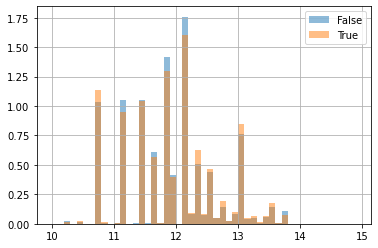

In [92]:
leg = []
for target, group in balance.groupby("target"):
    group.amt_credit_limit_actual_scaled.hist(density=True, alpha=0.5, bins=np.arange(10, 15, 0.1))
    leg.append(target)
    print(f"{target} 0 비율: {(group.amt_credit_limit_actual_scaled == 0).mean()*100:.2f}%")
plt.legend(leg)
plt.show()

In [85]:
balance.amt_credit_limit_actual.value_counts()

0         753823
180000    529292
135000    430142
45000     329932
90000     319996
           ...  
666000         4
783000         3
742500         3
693000         1
625500         1
Name: amt_credit_limit_actual, Length: 181, dtype: int64

### amt_drawings_atm_current

In [94]:
balance.amt_drawings_atm_current + 1

0               0.0
1            2250.0
2               0.0
3            2250.0
4               0.0
             ...   
3840307         NaN
3840308         0.0
3840309    270000.0
3840310         NaN
3840311         0.0
Name: amt_drawings_atm_current, Length: 3840312, dtype: float64